<a href="https://colab.research.google.com/github/velozo27/TCC-Pedro-Velozo-ENG1132/blob/main/SRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime

In [41]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [43]:
!ls /content/gdrive/MyDrive/TCC/code


2023-04-20_20:51:19_srcnn_avg_loss_0.1607180961540767
2023-04-22_19:32:41_srcnn_avg_loss_0.11218196153640747
2023-04-22_21:44:18_srcnn_avg_loss_0
2023-04-22_23:43:51_srcnn_avg_loss_0.09928497139896665
srcnn_avg_loss_0.21316420606204442
srcnn_avg_loss_0.21332289704254695
SRCNN.ipynb


In [44]:
class SRCNN(nn.Module):
    def __init__(self) -> None:
        super(SRCNN, self).__init__()
        # 4.3 Model and Performance Trade-offs
        # Based on the basic network settings (i.e., f1 = 9, f2 = 1, f3 = 5, n1 = 64, and n2 = 32),
        f1 = 9
        f2 = 1
        f3 = 5
        n1 = 64
        n2 = 32

        self.model = nn.Sequential(

            # 3.1.1 Patch extraction and representation
            nn.Conv2d(in_channels=3, out_channels=n1,
                      kernel_size=(f1, f1), padding=(f1-1)//2),
            nn.ReLU(),

            # 3.1.2 Non-linear mapping
            nn.Conv2d(in_channels=n1, out_channels=n2,
                      kernel_size=(f2, f2), padding=(f2-1)//2),
            nn.ReLU(),

            # 3.1.3 Reconstruction
            nn.Conv2d(in_channels=n2, out_channels=3,
                      kernel_size=(f3, f3), padding=(f3-1)//2),
        )

    def forward(self, x: torch.Tensor):
        x = self.model(x)
        return x


In [45]:
def train_loop(dataloader, model, loss_fn, optimizer, device="cuda" if torch.cuda.is_available() else "cpu"):
    size = len(dataloader.dataset)
    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return loss

def test_loop(dataloader, model, loss_fn, device="cuda" if torch.cuda.is_available() else "cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad(), tqdm(total=num_batches) as progress_bar:
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            progress_bar.update(1)

    test_loss /= num_batches

    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss


In [46]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [47]:
# garantir que é cuda
# assert device == "cuda"

In [48]:
# Instancianting the model
model = SRCNN()
model.to(device)

# hyperparameters
lr = 1e-5

In [49]:
class CustomImageDataset(Dataset):
    """
    A PyTorch dataset for loading a directory of images.

    Args:
        img_dir (str): The path to the directory containing the images.
        transform (callable, optional): A function/transform that takes in an image and returns a
            transformed version. Default: None.
        target_transform (callable, optional): A function/transform that takes in the target and
            transforms it. Default: None.
    """

    def __init__(self, img_dir: str, transform = None, target_transform = None):
        """
        Initializes a new instance of the CustomImageDataset class.

        Args:
            img_dir (str): The path to the directory containing the images.
            transform (callable, optional): A function/transform that takes in an image and returns a
                transformed version. Default: None.
            target_transform (callable, optional): A function/transform that takes in the target and
                transforms it. Default: None.
        """
        self.file_lst = list(os.listdir(img_dir))
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self) -> int:
        """
        Returns the number of images in the dataset.

        Returns:
            The number of images in the dataset.
        """
        return len(self.file_lst)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns the image at the specified index in the dataset.

        Args:
            idx (int): The index of the image to return.

        Returns:
            A tuple containing the transformed input image and the transformed target image.
        """
        img_path = self.file_lst[idx]
        image = read_image(f"{self.img_dir}/{img_path}")
        image_x = image.detach().clone()
        image_y = image.detach().clone()
        if self.transform:
            image_x = self.transform(image_x)
        if self.target_transform:
            image_y = self.target_transform(image_y)
        return image_x.float() / 255, image_y.float() / 255

In [50]:
class ImageHelper:
    """
    A helper class for working with image data in PyTorch.
    """

    def __init__(self):
        """
        Initializes a new instance of the ImageHelper class.
        """
        return

    def show_tensor_as_image(self, tensor: torch.Tensor):
        """
        Displays an image represented as a PyTorch tensor.

        Args:
            tensor: A PyTorch tensor representing the image. The tensor should have shape (C, H, W),
                where C is the number of channels, H is the height, and W is the width.

        Returns:
            None
        """
        plt.figure()
        tensor_np = tensor.detach().numpy()
        plt.imshow(tensor_np.transpose((1, 2, 0)))
        plt.show()


In [51]:
transform_x = transforms.Compose([
    # resize image to 33x33 and downsample by BICUBIC interpolation
    transforms.Resize((33, 33), interpolation=Image.BICUBIC),
    # resize image to 256x256
    transforms.Resize((256, 256), interpolation=Image.BICUBIC)
])

transform_y = transforms.Compose([
    # resize image to 256x256 and downsample by BICUBIC interpolation
    transforms.Resize((256, 256), interpolation=Image.BICUBIC),
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir="/content/gdrive/MyDrive/TCC/datasets/DIV2K_train_HR", transform=transform_x, target_transform=transform_y)
test_data_set = CustomImageDataset(
    img_dir="/content/gdrive/MyDrive/TCC/datasets/DIV2K_valid_HR", transform=transform_x, target_transform=transform_y)

train_dataloader = DataLoader(train_data_set, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data_set, batch_size=16)

In [52]:
# 3.3 Training
# The loss is minimized using stochastic gradient descent with the standard backpropagation
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# we use Mean Squared Error (MSE) as the loss function:
loss_fn = nn.MSELoss()

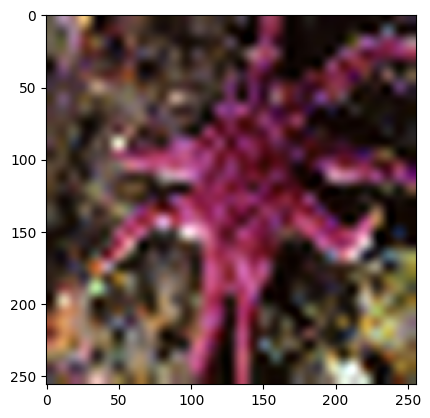

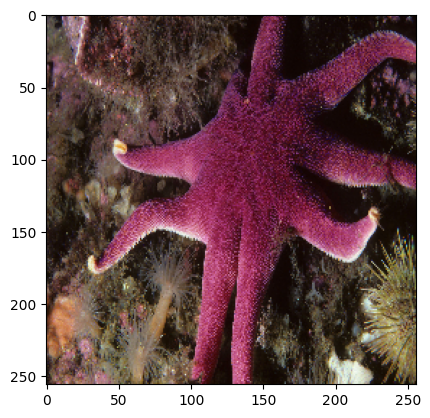

In [53]:
# example of training image
ImageHelperInstance = ImageHelper()

for a, b in train_data_set:
    ImageHelperInstance.show_tensor_as_image(a)
    ImageHelperInstance.show_tensor_as_image(b)
    break

# for X, y in train_dataloader:
#     ImageHelperInstance.show_tensor_as_image(X[0])
#     ImageHelperInstance.show_tensor_as_image(y[0])
#     break


# CARREGAR O MODELO

In [54]:
model_load_path_name = f"/content/gdrive/My Drive/TCC/code/2023-04-22_23:43:51_srcnn_avg_loss_0.09928497139896665"

if torch.cuda.is_available():
  model.load_state_dict(torch.load(model_load_path_name))
else:
  model.load_state_dict(torch.load(model_load_path_name, map_location=torch.device('cpu')))


In [55]:
%%time
train_loss = 0
test_loss = 0
epochs = 15 # 140 - 155 agora
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss = test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


  2%|▏         | 1/54 [00:13<11:32, 13.07s/it]

loss: 0.102867  [    0/  850]


100%|██████████| 7/7 [00:29<00:00,  4.25s/it]


Test Error: 
 Avg loss: 0.098466 

Epoch 2
-------------------------------


  2%|▏         | 1/54 [00:06<06:01,  6.81s/it]

loss: 0.111796  [    0/  850]


100%|██████████| 7/7 [00:31<00:00,  4.43s/it]


Test Error: 
 Avg loss: 0.097646 

Epoch 3
-------------------------------


  2%|▏         | 1/54 [00:08<07:09,  8.10s/it]

loss: 0.106874  [    0/  850]


100%|██████████| 7/7 [00:30<00:00,  4.35s/it]


Test Error: 
 Avg loss: 0.096834 

Epoch 4
-------------------------------


  2%|▏         | 1/54 [00:07<07:03,  8.00s/it]

loss: 0.087982  [    0/  850]


100%|██████████| 7/7 [00:30<00:00,  4.31s/it]


Test Error: 
 Avg loss: 0.096032 

Epoch 5
-------------------------------


  2%|▏         | 1/54 [00:07<06:48,  7.70s/it]

loss: 0.094194  [    0/  850]


100%|██████████| 7/7 [00:30<00:00,  4.31s/it]


Test Error: 
 Avg loss: 0.095226 

Epoch 6
-------------------------------


  2%|▏         | 1/54 [00:07<07:01,  7.95s/it]

loss: 0.090289  [    0/  850]


100%|██████████| 7/7 [00:31<00:00,  4.44s/it]


Test Error: 
 Avg loss: 0.094434 

Epoch 7
-------------------------------


  2%|▏         | 1/54 [00:07<06:22,  7.22s/it]

loss: 0.105678  [    0/  850]


100%|██████████| 7/7 [00:30<00:00,  4.42s/it]


Test Error: 
 Avg loss: 0.093641 

Epoch 8
-------------------------------


  2%|▏         | 1/54 [00:08<07:06,  8.05s/it]

loss: 0.084113  [    0/  850]


100%|██████████| 7/7 [00:29<00:00,  4.23s/it]


Test Error: 
 Avg loss: 0.092855 

Epoch 9
-------------------------------


  2%|▏         | 1/54 [00:08<07:08,  8.09s/it]

loss: 0.091717  [    0/  850]


100%|██████████| 7/7 [00:33<00:00,  4.79s/it]


Test Error: 
 Avg loss: 0.092084 

Epoch 10
-------------------------------


  2%|▏         | 1/54 [00:14<12:47, 14.47s/it]

loss: 0.100628  [    0/  850]


100%|██████████| 7/7 [00:29<00:00,  4.26s/it]


Test Error: 
 Avg loss: 0.091313 

Epoch 11
-------------------------------


  2%|▏         | 1/54 [00:08<07:39,  8.66s/it]

loss: 0.109638  [    0/  850]


100%|██████████| 7/7 [00:30<00:00,  4.30s/it]


Test Error: 
 Avg loss: 0.090547 

Epoch 12
-------------------------------


  2%|▏         | 1/54 [00:07<06:55,  7.84s/it]

loss: 0.090954  [    0/  850]


100%|██████████| 7/7 [00:29<00:00,  4.25s/it]


Test Error: 
 Avg loss: 0.089780 

Epoch 13
-------------------------------


  2%|▏         | 1/54 [00:08<07:07,  8.07s/it]

loss: 0.086687  [    0/  850]


100%|██████████| 7/7 [00:29<00:00,  4.25s/it]


Test Error: 
 Avg loss: 0.089021 

Epoch 14
-------------------------------


  2%|▏         | 1/54 [00:08<07:23,  8.37s/it]

loss: 0.092242  [    0/  850]


100%|██████████| 7/7 [00:33<00:00,  4.84s/it]


Test Error: 
 Avg loss: 0.088269 

Epoch 15
-------------------------------


  2%|▏         | 1/54 [00:07<06:44,  7.62s/it]

loss: 0.083789  [    0/  850]


100%|██████████| 7/7 [00:30<00:00,  4.35s/it]

Test Error: 
 Avg loss: 0.087521 

Done!
CPU times: user 1h 17min 47s, sys: 29min 5s, total: 1h 46min 53s
Wall time: 1h 49min 12s


255


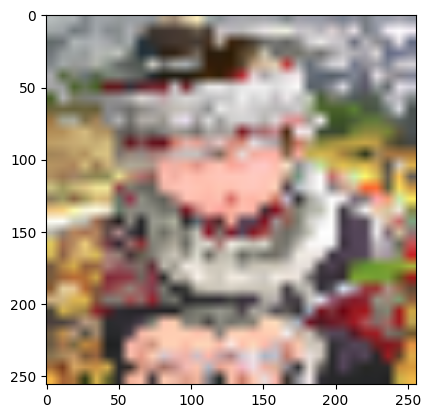

In [56]:
new_image = Image.open('/content/gdrive/MyDrive/TCC/datasets/Set14/comic.png')
transform = transforms.Compose([
    transforms.ToTensor(),
    # resize image to 33x33 and downsample by BICUBIC interpolation
    transforms.Resize((33, 33), interpolation=Image.LINEAR),
    # resize image to 256x256
    transforms.Resize((256, 256), interpolation=Image.LINEAR)
])


new_image_lr = transform(new_image)
print(np.array(new_image).max())
ImageHelperInstance.show_tensor_as_image(new_image_lr)


In [57]:
new_image_lr.dtype

torch.float32

In [58]:
new_image_lr.max()

tensor(1.)

In [59]:
new_image_sr = model(new_image_lr.to(device))

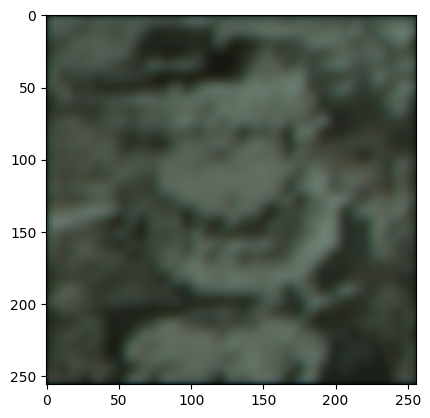

In [60]:
import matplotlib.pyplot as plt

plt.figure()
new_image_sr_np = new_image_sr.cpu().detach().numpy()
plt.imshow(new_image_sr_np.transpose((1, 2, 0)))
plt.show()

# SALVAR MODELO


In [61]:
date = datetime.today().strftime('%Y-%m-%d %H:%M:%S').replace(' ', '_')
model_save_path_name = f"/content/gdrive/My Drive/TCC/code/{date}_srcnn_avg_loss_{test_loss}"
torch.save(model.state_dict(), model_save_path_name)

In [62]:
new_image_sr = model(new_image_lr.to(device))

In [63]:
new_image_sr.dtype

torch.float32

In [64]:
new_image_sr.max()

tensor(0.5046, grad_fn=<MaxBackward1>)

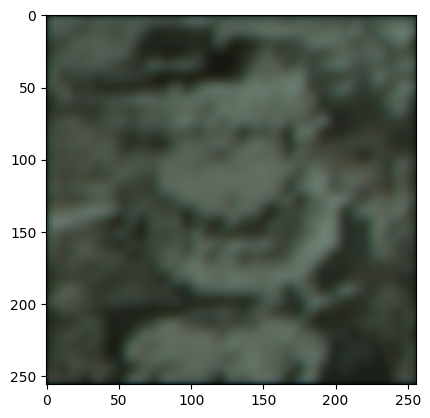

In [65]:
import matplotlib.pyplot as plt

plt.figure()
new_image_sr_np = new_image_sr.cpu().detach().numpy()
plt.imshow(new_image_sr_np.transpose((1, 2, 0)))
plt.show()